### Load Python Package

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from datetime import date
import seaborn as sns
from shapely.geometry import Point, MultiPolygon
import geojson
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy as sp
from statsmodels.graphics import utils
import statsmodels.stats.api as sms
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from math import sqrt
%matplotlib inline

In [70]:
def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

In [71]:
def haversine_array(latitude1, longitude1, latitude2, longitude2):
    latitude1, longitude1, latitude2, longitude2 = map(np.radians, (latitude1, longitude1, latitude2, longitude2))
    # The average radius of the earth
    # in km
    AVG_EARTH_RADIUS = 6371
    lat = latitude2 - latitude1
    lng = longitude2 - longitude1
    d = np.sin(lat * 0.5) ** 2 + np.cos(latitude1) * np.cos(latitude2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [75]:
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [56]:
def restday(yr,month,day,holidays):
    '''
    Output:
        is_rest: a list of Boolean variable indicating if the sample occurred in the rest day.
        is_weekend: a list of Boolean variable indicating if the sample occurred in the weekend.
    '''
    is_rest    = [None]*len(yr)
    is_weekend = [None]*len(yr)
    i=0
    for yy,mm,dd in zip(yr,month,day):        
        is_weekend[i] = date(yy,mm,dd).isoweekday() in (6,7)
        is_rest[i]    = is_weekend[i] or date(yy,mm,dd) in holidays 
        i+=1
    return is_rest,is_weekend

In [63]:
def CheckProvince(daf, long1, lati1):
    gpsPointIs = Point(long1,lati1)
    provinceIs = ','.join(list(filter(lambda x: daf[x].contains(gpsPointIs), daf.keys())))
    if provinceIs =='':
        provinceIs = 'outward'
    return provinceIs

In [67]:
def SameProvince(x):
    if x['pickup_Province']==x['dropoff_Province']:
        return 1
    else:
        return 0
test['pickup_dropoff_same_Province']= test.apply(lambda x:SameProvince(x),axis = 1)

In [72]:
def CheckAirport(df, long, lati, province, f):
    if province == f:
        filterIs = list(filter(lambda x: haversine_array(long,lati,df[x][0],df[x][1]) < 1.5, df))
        if not filterIs:
            out = 'N'
        else:
            out = filterIs[0]
    else:
        out ='N'
    return out

### Load Training dataet

In [20]:
train = pd.read_csv('./data/transformed_train.csv')
print ("Training data has {} rows and {} columns".format(train.shape[0],train.shape[1]))
print ("data : {}".format(train.shape[0]))
print ("Feature : {}".format(train.shape[1]))

Training data has 701778 rows and 32 columns
data : 701778
Feature : 32


In [21]:
train.drop(['minute','month','day'],axis = 1,inplace = True)

In [22]:
train.shape

(701778, 29)

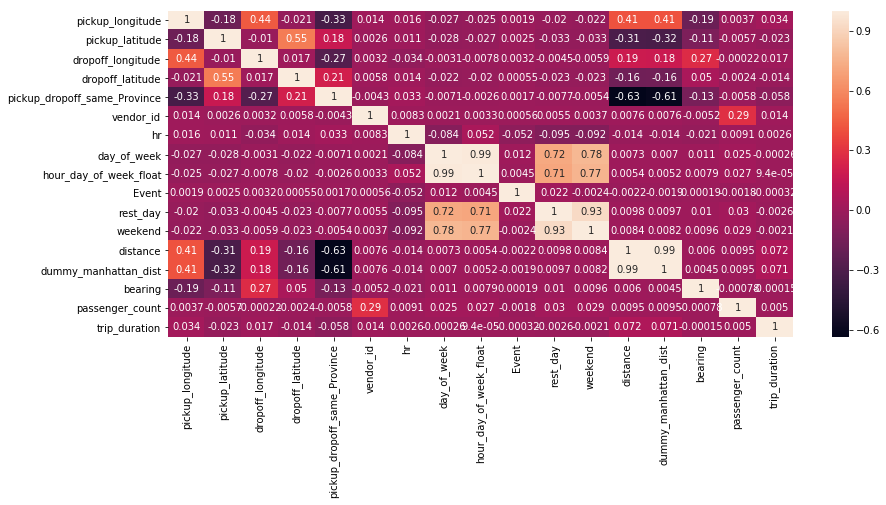

In [23]:
identical = 'id'
depVal = 'trip_duration'
poslist =['pickup_longitude',
          'pickup_latitude',
          'dropoff_longitude',
          'dropoff_latitude']
posCatList = ['pickup_Province','dropoff_Province','pickup_dropoff_same_Province','pickup_Airport','dropoff_Airport']

notUseTimeList = ['pickup_datetime', 'dropoff_datetime', 'pickup_date', 'pickup_time']
notUseSpeedList = ['speed_kmph', 'speed_kmph_dummy']
cateList = ['vendor_id', 'store_and_fwd_flag','hr', 'day_of_week',
       'hour_day_of_week_float', 'Event', 'rest_day', 'weekend']

realList = ['distance','dummy_manhattan_dist', 'bearing', 'passenger_count']
totalCorr = train[poslist+posCatList+cateList+realList+[depVal]].corr()
plt.figure(figsize=(14,6))
sns.heatmap(totalCorr, annot=True)
plt.show()

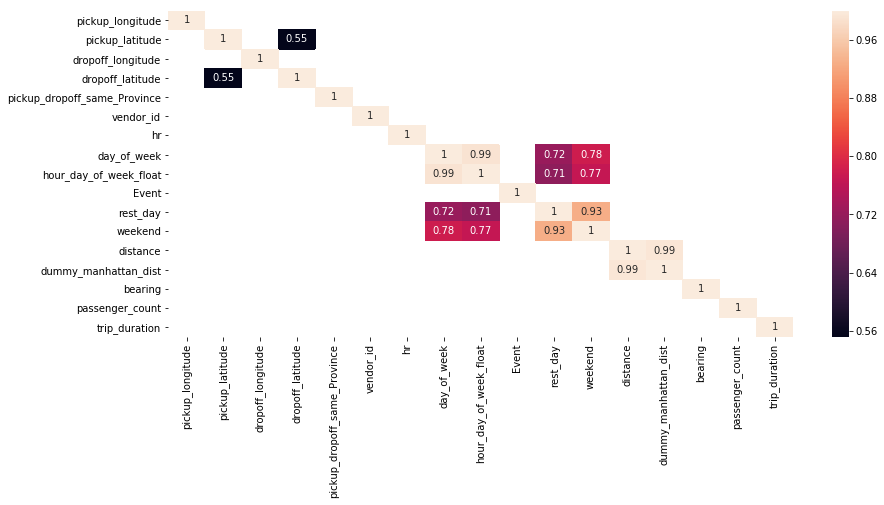

In [24]:
plt.figure(figsize=(14,6))
sns.heatmap(totalCorr[totalCorr>0.5],annot=True)

* 상관계수 > 0.5
> * dropoff_latitude - pickup_latitude
> * day_of_week - rest_day, weekend, hour_day_of_week_float
> * hour_day_of_week_float - rest_day, weekend, day_of_week
> * rest_day : weekend, hour_day_of_week_float, day_of_week
> * **weekend** : rest_day, hour_day_of_week_float, day_of_week
> * distance : dummy_manhattan_dist
> * dummy_manhattan_dist : distance

In [176]:
#1
formulaIs ='I(np.log(trip_duration)) ~ I(np.log(dummy_manhattan_dist+0.1))+scale(bearing)+C(pickup_Province):C(dropoff_Province) +C(vendor_id)+C(hr):C(rest_day)+0'
fList = ['dummy_manhattan_dist','bearing','dropoff_Province','pickup_Province','hr','rest_day']
#2
formulaIs ='I(np.log(trip_duration)) ~ I(np.log(distance+0.1))+scale(bearing)+C(pickup_Province)+C(dropoff_Province) +C(hr):C(rest_day)+0'
fList = ['distance','bearing','dropoff_Province','pickup_Province','hr','rest_day','vendor_id']

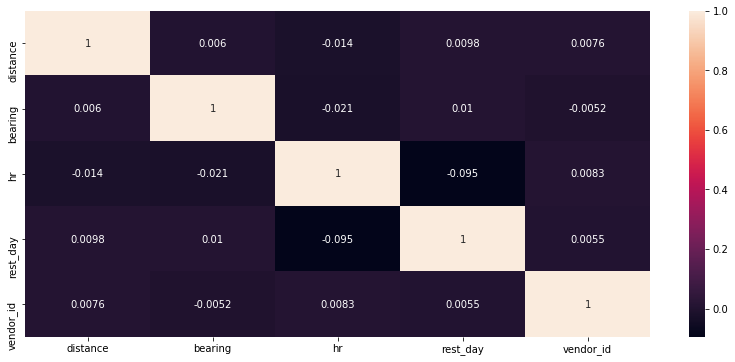

In [177]:
plt.figure(figsize=(14,6))
modelCorr = train[fList].corr()
sns.heatmap(modelCorr, annot =True)

In [178]:
#2
#formulaIs ='np.log(trip_duration) ~ I(np.log(dummy_manhattan_dist+0.1))+I(np.log(distance+0.1))+scale(bearing) +C(pickup_Province)*C(dropoff_Airport)+C(pickup_Airport)*C(dropoff_Province)+C(hr):C(day_of_week)+0'
#fList = ['dummy_manhattan_dist','distance','bearing','pickup_Province','dropoff_Airport','dropoff_Province','pickup_Airport','hr','day_of_week']

#3
#formulaIs ='I(np.log(trip_duration)) ~ I(np.log(dummy_manhattan_dist+0.1))+I(np.log(distance+0.1))+scale(bearing)+C(pickup_Province)*C(dropoff_Province) +C(hr):C(rest_day) + 0'
#fList = ['dummy_manhattan_dist','distance','bearing','dropoff_Airport','dropoff_Province','pickup_Airport','pickup_Province','hr','rest_day']

#4
#formulaIs ='I(np.log(trip_duration)) ~ I(np.log(dummy_manhattan_dist+0.1))+I(np.log(distance+0.1))+scale(bearing) + C(pickup_dropoff_same_Province)+C(hr):C(rest_day)+0'
#fList = ['dummy_manhattan_dist','distance','bearing','pickup_dropoff_same_Province','hr','weekend']

model = sm.OLS.from_formula(formulaIs,data = train)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     I(np.log(trip_duration))   R-squared:                       0.637
Model:                                  OLS   Adj. R-squared:                  0.637
Method:                       Least Squares   F-statistic:                 2.088e+04
Date:                      Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                              17:39:09   Log-Likelihood:            -4.7480e+05
No. Observations:                    701778   AIC:                         9.497e+05
Df Residuals:                        701718   BIC:                         9.504e+05
Df Model:                                59                                         
Covariance Type:                  nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
C(pickup_Province)[Bronx]                5.5317      0.020    270.999      0.000       5.492       5.572
C(pickup_Province)[Brooklyn]             5.3252      0.010    549.069      0.000       5.306       5.344
C(pickup_Province)[Manhattan]            5.3875      0.009    627.272      0.000       5.371       5.404
C(pickup_Province)[Queens]               5.2721      0.009    586.187      0.000       5.254       5.290
C(pickup_Province)[Staten Island]        7.1312      0.094     76.174      0.000       6.948       7.315
C(pickup_Province)[outward]              5.2542      0.023    232.173      0.000       5.210       5.299
C(dropoff_Province)[T.Brooklyn]          0.2508      0.008     32.129      0.000       0.236       0.266
C(dropoff_Province)[T.Manhattan]         0.1821      0.007     24.451      0.000       0.168       0.197
C(dropoff_Province)[T.Queens]            0.1082      0.008     13.920      0.000       0.093       0.123
C(dropoff_Province)[T.Staten Island]     0.1282      0.038      3.360      0.001       0.053       0.203
C(dropoff_Province)[T.outward]           0.0195      0.012      1.636      0.102      -0.004       0.043
C(rest_day)[T.True]                      0.1730      0.006     28.825      0.000       0.161       0.185
C(hr)[T.1]:C(rest_day)[False]           -0.0575      0.007     -8.236      0.000      -0.071      -0.044
C(hr)[T.2]:C(rest_day)[False]           -0.0810      0.008     -9.918      0.000      -0.097      -0.065
C(hr)[T.3]:C(rest_day)[False]           -0.1088      0.009    -11.597      0.000      -0.127      -0.090
C(hr)[T.4]:C(rest_day)[False]           -0.1548      0.010    -16.156      0.000      -0.174      -0.136
C(hr)[T.5]:C(rest_day)[False]           -0.1936      0.008    -24.188      0.000      -0.209      -0.178
C(hr)[T.6]:C(rest_day)[False]           -0.0799      0.006    -13.355      0.000      -0.092      -0.068
C(hr)[T.7]:C(rest_day)[False]            0.1979      0.005     37.246      0.000       0.187       0.208
C(hr)[T.8]:C(rest_day)[False]            0.4054      0.005     78.184      0.000       0.395       0.416
C(hr)[T.9]:C(rest_day)[False]            0.4664      0.005     88.839      0.000       0.456       0.477
C(hr)[T.10]:C(rest_day)[False]           0.4719      0.005     87.814      0.000       0.461       0.482
C(hr)[T.11]:C(rest_day)[False]           0.4866      0.005     90.609      0.000       0.476       0.497
C(hr)[T.12]:C(rest_day)[False]           0.4759      0.005     89.301      0.000       0.466       0.486
C(hr)[T.13]:C(rest_day)[False]           0.4408      0.005     82.587      0.000       0.430       0.451
C(hr)[T.14]:C(rest_day)[False]           0.4435      0.005     84.271      0.

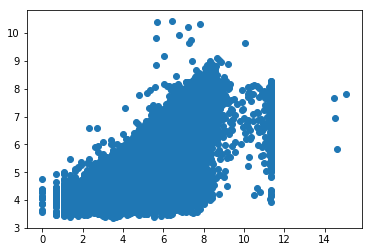

In [173]:
y_new = result.predict(train[fList])
y = train.apply(lambda x:np.log(x.trip_duration),axis=1)
plt.scatter(y,y_new)


In [96]:
inf = result.get_influence()
hat = inf.hat_matrix_diag
print('hat.sum() =',hat.sum())
x_new = train[fList]
y_new = result.predict()

hat.sum() = 81.9999999994


C:\Users\pc\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:309: RuntimeWarning: invalid value encountered in sqrt
  return  self.results.resid / sigma / np.sqrt(1 - hii)
C:\Users\pc\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\pc\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\pc\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


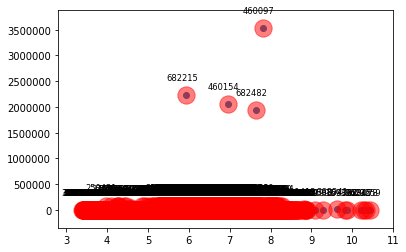

16271

In [97]:
cooks_d2, pvals = inf.cooks_distance
fox_cr = 4 / (len(train['trip_duration']) - 2)
idx = np.where(cooks_d2 > fox_cr)[0]

ax = plt.subplot()
plt.scatter(y_new,train['trip_duration'])
plt.scatter(y_new[idx], train['trip_duration'][idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx, 
                    list(zip(y_new[idx], train['trip_duration'][idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
plt.show()
len(idx)

In [98]:
sm.stats.anova_lm(result,typ =2)

,sum_sq,df,F,PR(>F)
C(pickup_Province),91358.181993,6.0,68054.283518,0.000000e+00
C(dropoff_Province),416.770426,5.0,372.551364,0.000000e+00
C(hr),12147.805815,23.0,2360.637342,0.000000e+00
C(rest_day),1715.399220,1.0,7666.982573,0.000000e+00
C(pickup_Province):C(dropoff_Province),110.553379,25.0,19.764748,1.378555e-88
C(hr):C(rest_day),4489.620606,23.0,872.451060,0.000000e+00
I(np.log(dummy_manhattan_dist + 0.1)),1740.624031,1.0,7779.724948,0.000000e+00
I(np.log(distance + 0.1)),8877.968361,1.0,39680.109394,0.000000e+00
scale(bearing),489.422363,1.0,2187.474895,0.000000e+00
Residual,156996.414131,701696.0,NaN,NaN


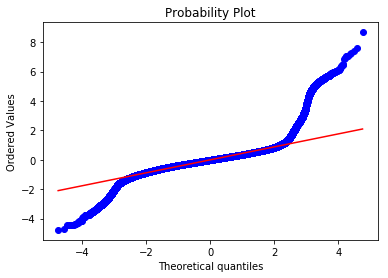

In [99]:
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [100]:
cv = KFold(n_splits=4, shuffle=True, random_state=0)

0.645371893067
0.647819910476
0.646916297346
0.645869724089


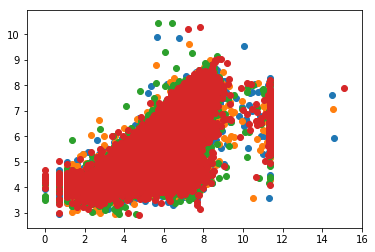

In [101]:
formulaIs ='I(np.log(trip_duration)) ~ I(np.log(dummy_manhattan_dist+0.1))+I(np.log(distance+0.1))+bearing +C(pickup_Province)*C(dropoff_Airport)+C(pickup_Airport)*C(dropoff_Province) + C(pickup_dropoff_same_Province)+C(hr)*C(day_of_week)+ 0'
fList = ['dummy_manhattan_dist','distance','bearing','dropoff_Airport','dropoff_Province','pickup_Airport','pickup_Province','pickup_dropoff_same_Province','hr','day_of_week','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']

#formulaIs ='I(np.log(trip_duration)) ~ I(np.log(dummy_manhattan_dist+0.1))+bearing +C(dropoff_Province)*C(pickup_Province)+C(hr)*C(day_of_week) + pickup_longitude+pickup_latitude+dropoff_longitude+dropoff_latitude + 0'
#fList = ['dummy_manhattan_dist','bearing','dropoff_Province','pickup_Province','hr','day_of_week','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']

for train_index, test_index in cv.split(train):
    cTrainDe = train.loc[train_index][fList+['trip_duration']]
    #cTrainIn = train.loc[train_index]
    modelc = sm.OLS.from_formula(formulaIs,cTrainDe)
    resultc = modelc.fit()
    x = resultc.rsquared
    print (x)
    cTest = train.loc[test_index][fList]
    #cTestOut = train.loc[test_index]['trip_duration']    
    yc_new = resultc.predict(cTest[fList])
    yc = train.loc[test_index].apply(lambda x:np.log(x.trip_duration),axis=1)
    #y = train.loc[train_index]['trip_duration']
    plt.scatter(yc,y_newc)

In [102]:
xTrain = model.fit_regularized(alpha=0.01,L1_wt=1)

In [103]:
xTrain.params

C(pickup_Province)[Bronx]                                             0.000000
C(pickup_Province)[Brooklyn]                                          5.024678
C(pickup_Province)[Manhattan]                                         5.681069
C(pickup_Province)[Queens]                                            5.367731
C(pickup_Province)[Staten Island]                                     0.000000
C(pickup_Province)[outward]                                           0.000000
C(dropoff_Province)[T.Brooklyn]                                       0.000000
C(dropoff_Province)[T.Manhattan]                                      0.000000
C(dropoff_Province)[T.Queens]                                         0.000000
C(dropoff_Province)[T.Staten Island]                                  0.000000
C(dropoff_Province)[T.outward]                                        0.000000
C(hr)[T.1]                                                            0.000000
C(hr)[T.2]                                          

In [104]:
filter_X =train[:]
filter_X.drop(idx,0,inplace = True)

filter_X.tail()
print (train.shape)
print (filter_X.shape)

(701778, 29)
(685507, 29)


C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [105]:
modela = sm.OLS.from_formula(formulaIs,data = filter_X)
resulta = modela.fit()
resulta.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     I(np.log(trip_duration))   R-squared:                       0.737
Model:                                  OLS   Adj. R-squared:                  0.737
Method:                       Least Squares   F-statistic:                     9658.
Date:                      Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                              10:31:40   Log-Likelihood:            -2.8871e+05
No. Observations:                    685507   AIC:                         5.778e+05
Df Residuals:                        685307   BIC:                         5.801e+05
Df Model:                               199                                         
Covariance Type:                  nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
C(pickup_Province)[Bronx]                                   -3.423e+07    6.4e+07     -0.534      0.593    -1.6e+08    9.13e+07
C(pickup_Province)[Brooklyn]                                    5.0809      0.064     78.961      0.000       4.955       5.207
C(pickup_Province)[Manhattan]                                   5.0479      0.037    136.582      0.000       4.975       5.120
C(pickup_Province)[Queens]                                      5.0392      0.042    118.830      0.000       4.956       5.122
C(pickup_Province)[Staten Island]                           -1.711e+07    3.2e+07     -0.534      0.593   -7.99e+07    4.57e+07
C(pickup_Province)[outward]                                 -1.711e+07    3.2e+07     -0.534      0.593   -7.99e+07    4.57e+07
C(dropoff_Airport)[T.L]                                     -1.054e+04   1.97e+04     -0.534      0.593   -4.92e+04    2.81e+04
C(dropoff_Airport)[T.N]                                      3.423e+07    6.4e+07      0.534      0.593   -9.13e+07     1.6e+08
C(pickup_Airport)[T.L]                                          0.0943      0.044      2.166      0.030       0.009       0.180
C(pickup_Airport)[T.N]                                          0.0395      0.036      1.107      0.268      -0.030       0.109
C(dropoff_Province)[T.Brooklyn]                                 0.2018      0.036      5.606      0.000       0.131       0.272
C(dropoff_Province)[T.Manhattan]                                0.2198      0.035      6.231      0.000       0.151       0.289
C(dropoff_Province)[T.Queens]                                   0.1272      0.036      3.518      0.000       0.056       0.198
C(dropoff_Province)[T.Staten Island]                           -0.0191      0.263     -0.073      0.942      -0.535       0.497
C(dropoff_Province)[T.outward]                                 -0.0201      0.052     -0.385      0.700      -0.122       0.082
C(pickup_dropoff_same_Province)[T.1]                           -0.0358      0.003    -11.850      0.000      -0.042      -0.030
C(hr)[T.1]                                                     -0.0227      0.014     -1.635      0.102      -0.050       0.005
C(hr)[T.2]                                                     -0.0217      0.017     -1.297      0.195      -0.054       0.011
C(hr)[T.3]                                                     -0.0080      0.019     -0.422      0.673      -0.045       0.029
C(hr)[T.4]                                                     -0.0648      0.018     -3.581      0.000      -0.100      -0.029
C(hr)[T.5]                                                     -0.0733   

In [154]:
y_newa = resulta.predict(filter_X[fList])
ya = filter_X.apply(lambda x:np.log(x.trip_duration),axis=1)
#ya = filter_X['trip_duration']
plt.scatter(ya,y_newa)

PatsyError: Error evaluating factor: NameError: name 'dropoff_Airport' is not defined
    I(np.log(trip_duration)) ~ I(np.log(dummy_manhattan_dist+0.1))+I(np.log(distance+0.1))+bearing +C(pickup_Province)*C(dropoff_Airport)+C(pickup_Airport)*C(dropoff_Province) + C(pickup_dropoff_same_Province)+C(hr)*C(day_of_week)+ 0
                                                                                                                       ^^^^^^^^^^^^^^^^^^

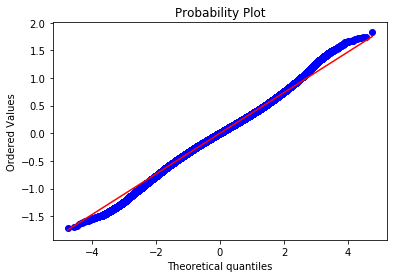

In [107]:
sp.stats.probplot(resulta.resid, plot=plt)
plt.show()

In [108]:
filter_X = filter_X[:][ (filter_X['passenger_count']!=0) 
                       & (filter_X['dummy_manhattan_dist']!=0) 
                       & (filter_X['distance']!=0) 
                       & (filter_X['speed_kmph_dummy']<100)]

In [109]:
modelb = sm.OLS.from_formula(formulaIs,data = filter_X)
resultb = modelb.fit()
resultb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     I(np.log(trip_duration))   R-squared:                       0.736
Model:                                  OLS   Adj. R-squared:                  0.736
Method:                       Least Squares   F-statistic:                     9607.
Date:                      Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                              10:33:23   Log-Likelihood:            -2.8780e+05
No. Observations:                    685054   AIC:                         5.760e+05
Df Residuals:                        684854   BIC:                         5.783e+05
Df Model:                               199                                         
Covariance Type:                  nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
C(pickup_Province)[Bronx]                                    -4.46e+07   8.63e+07     -0.517      0.605   -2.14e+08    1.25e+08
C(pickup_Province)[Brooklyn]                                    5.0756      0.064     78.959      0.000       4.950       5.202
C(pickup_Province)[Manhattan]                                   5.0418      0.037    136.545      0.000       4.969       5.114
C(pickup_Province)[Queens]                                      5.0295      0.042    118.371      0.000       4.946       5.113
C(pickup_Province)[Staten Island]                            -2.23e+07   4.32e+07     -0.517      0.605   -1.07e+08    6.23e+07
C(pickup_Province)[outward]                                  -2.23e+07   4.32e+07     -0.517      0.605   -1.07e+08    6.23e+07
C(dropoff_Airport)[T.L]                                      6323.8303   1.22e+04      0.517      0.605   -1.77e+04    3.03e+04
C(dropoff_Airport)[T.N]                                       4.46e+07   8.63e+07      0.517      0.605   -1.25e+08    2.14e+08
C(pickup_Airport)[T.L]                                          0.0958      0.043      2.203      0.028       0.011       0.181
C(pickup_Airport)[T.N]                                          0.0395      0.036      1.111      0.267      -0.030       0.109
C(dropoff_Province)[T.Brooklyn]                                 0.2026      0.036      5.636      0.000       0.132       0.273
C(dropoff_Province)[T.Manhattan]                                0.2197      0.035      6.237      0.000       0.151       0.289
C(dropoff_Province)[T.Queens]                                   0.1266      0.036      3.506      0.000       0.056       0.197
C(dropoff_Province)[T.Staten Island]                           -0.0191      0.263     -0.073      0.942      -0.534       0.496
C(dropoff_Province)[T.outward]                                 -0.0197      0.052     -0.378      0.705      -0.122       0.082
C(pickup_dropoff_same_Province)[T.1]                           -0.0345      0.003    -11.416      0.000      -0.040      -0.029
C(hr)[T.1]                                                     -0.0224      0.014     -1.613      0.107      -0.050       0.005
C(hr)[T.2]                                                     -0.0219      0.017     -1.310      0.190      -0.055       0.011
C(hr)[T.3]                                                     -0.0075      0.019     -0.395      0.693      -0.045       0.030
C(hr)[T.4]                                                     -0.0652      0.018     -3.606      0.000      -0.101      -0.030
C(hr)[T.5]                                                     -0.0735   

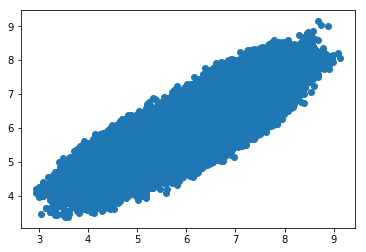

In [110]:
y_newb = resultb.predict(filter_X[fList])
yb = filter_X.apply(lambda x:np.log(x.trip_duration),axis=1)
plt.scatter(yb,y_newb)

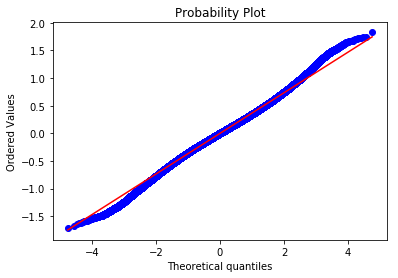

In [111]:
sp.stats.probplot(resultb.resid, plot=plt)
plt.show()

#### Dependent Variable
> * trip_duration
>  * 100000(sec) 이상의 값을 보이는 데이터가 4개 존재함

In [45]:
test = pd.read_csv('./data/test.csv')
print ("Training data has {} rows and {} columns".format(test.shape[0],test.shape[1]))
print ("data : {}".format(test.shape[0]))
print ("Feature : {}".format(test.shape[1]))

Training data has 346797 rows and 9 columns
data : 346797
Feature : 9


In [46]:
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

In [47]:
test['hr'] = test['pickup_datetime'].dt.hour

In [48]:
test['year']=test['pickup_datetime'].dt.year

In [49]:
test['month'] = test['pickup_datetime'].dt.month

In [50]:
test['day_of_week'] = test['pickup_datetime'].dt.dayofweek

In [55]:
test['day'] = test['pickup_datetime'].dt.day

In [112]:
holiday = pd.read_csv('./data/NYC_2016Holidays.csv',sep=';')
holiday['Date'] = holiday['Date'].apply(lambda x: x + ' 2016')
holidays = [datetime.strptime(holiday.loc[i,'Date'], '%B %d %Y').date() for i in range(len(holiday))]

In [116]:
rest_day,weekend = restday(test.year,test.month,test.day,holidays)
timeTest = pd.DataFrame(index = range(len(test)))
timeTest = timeTest.assign(rest_day=rest_day)
timeTest = timeTest.assign(weekend=weekend)
test = pd.concat([test,timeTest],axis = 1)

In [62]:
with open('./data/BoroughBoundaries.geojson') as f:
    data = geojson.load(f)
das = dict()
for feature in data['features']:
    boro_name = feature['properties']['boro_name']
    shape_leng = feature['properties']['shape_leng']
    shape_area = feature['properties']['shape_area']
    coords = feature['geometry']['coordinates']
    binList = []
    print (boro_name, shape_area)
    for i in coords:
        for j in i:
            binList.append([j,[]])
    das[boro_name] = MultiPolygon(binList)

Staten Island 1623914222.74
Bronx 1186678192.09
Queens 3044779902.31
Brooklyn 1937477754.43
Manhattan 636479884.362


In [64]:
test['pickup_Province'] =test.apply(lambda x: CheckProvince(das, x.pickup_longitude, x.pickup_latitude), axis =1)

In [65]:
test['dropoff_Province'] = test.apply(lambda x: CheckProvince(das, x.dropoff_longitude, x.dropoff_latitude), axis =1)

In [118]:
test.to_csv('./data/transformed_test.csv',index = False)

In [69]:
with open('./data/Airport Point.geojson') as f:
    datas = geojson.load(f)
dot = dict()
for x in range(len(datas['features'])):
    name = datas['features'][x]['properties']['name']
    coords = datas['features'][x]['geometry']['coordinates']
    dot[name[0]] = coords

In [73]:
test['pickup_Airport'] = test.apply(lambda x: CheckAirport(dot, x.pickup_longitude, x.pickup_latitude, x.pickup_Province, 'Queens'), axis = 1)

In [74]:
test['dropoff_Airport'] = test.apply(lambda x: CheckAirport(dot, x.dropoff_longitude, x.dropoff_latitude, x.dropoff_Province, 'Queens'), axis = 1)

In [76]:
test['distance'] = test.apply(lambda x:haversine_array(x.pickup_latitude, x.pickup_longitude, x.dropoff_latitude, x.dropoff_longitude), axis =1 )

In [77]:
test['dummy_manhattan_dist'] = test.apply(lambda x:dummy_manhattan_distance(x.pickup_latitude, x.pickup_longitude, x.dropoff_latitude, x.dropoff_longitude), axis =1 )

In [78]:
test['bearing'] = test.apply(lambda x:bearing_array(x.pickup_latitude, x.pickup_longitude, x.dropoff_latitude, x.dropoff_longitude), axis =1 )

In [79]:
print (test.shape)
print (test['pickup_Province'].value_counts())
print (test['dropoff_Province'].value_counts())
print (test['pickup_Airport'].value_counts())
print (test['dropoff_Airport'].value_counts())

(346797, 22)
Manhattan        317848
Queens            21578
Brooklyn           6723
Bronx               324
outward             309
Staten Island        15
Name: pickup_Province, dtype: int64
Manhattan        304812
Queens            19047
Brooklyn          18806
Bronx              2358
outward            1665
Staten Island       109
Name: dropoff_Province, dtype: int64
N    332734
L      9428
J      4635
Name: pickup_Airport, dtype: int64
N    340257
L      4752
J      1788
Name: dropoff_Airport, dtype: int64


In [80]:
test.to_csv('./data/transformed_test.csv',index=False)

In [81]:
test = pd.read_csv('./data/transformed_test.csv')
print ("Training data has {} rows and {} columns".format(test.shape[0],test.shape[1]))
print ("data : {}".format(test.shape[0]))
print ("Feature : {}".format(test.shape[1]))

Training data has 346797 rows and 22 columns
data : 346797
Feature : 22


In [26]:
testy = resultb.predict(test[fList])

In [27]:
tx = pd.concat([test['id'],testy],axis=1)

In [28]:
tx

,id,0
0,id2332349,6.892749
1,id2013516,6.185159
2,id3719493,7.842722
3,id0376262,7.300766
4,id2105228,6.387913
5,id1276841,6.339212
6,id3016059,6.291779
7,id3952659,6.512010
8,id1255468,6.130016
9,id3049611,5.763472
